<a href="https://colab.research.google.com/github/AMAYadav/PROJECTS-/blob/main/market_risk_02_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
!pip install yfinance 
!pip install yoptions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [189]:
# ---------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ----------------
import yfinance as yf
import yoptions as yo

In [190]:
dir(yo)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'get_chain_greeks',
 'get_chain_greeks_date',
 'get_expiration_dates',
 'get_historical_option',
 'get_historical_option_ticker',
 'get_option_greeks',
 'get_option_greeks_ticker',
 'get_plain_chain',
 'get_plain_option',
 'get_plain_option_ticker',
 'get_underlying_price',
 'main']

In [191]:
year="2022"
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value="+year
data= pd.read_html(url,)[0]

data.head()

,Date,20 YR,30 YR,Extrapolation Factor,8 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,COUPON EQUIVALENT.1,52 WEEKS BANK DISCOUNT,COUPON EQUIVALENT.2,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,01/03/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.22,0.40,0.78,1.04,1.37,1.55,1.63,2.05,2.01
1,01/04/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.22,0.38,0.77,1.02,1.37,1.57,1.66,2.10,2.07
2,01/05/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.22,0.41,0.83,1.10,1.43,1.62,1.71,2.12,2.09
3,01/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23,0.45,0.88,1.15,1.47,1.66,1.73,2.12,2.09
4,01/07/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.24,0.43,0.87,1.17,1.50,1.69,1.76,2.15,2.11


In [192]:
# data[['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']]
df=data[['Date', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr',]].set_index('Date')
df.tail()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr
Date,,,,,,
12/19/2022,4.71,4.64,4.25,3.99,3.70,3.67
12/20/2022,4.70,4.64,4.25,4.03,3.79,3.78
12/21/2022,4.67,4.60,4.21,4.00,3.78,3.77
12/22/2022,4.66,4.64,4.24,4.02,3.79,3.77
12/23/2022,4.67,4.66,4.31,4.09,3.86,3.83


In [193]:
df.index = pd.to_datetime(df.index)

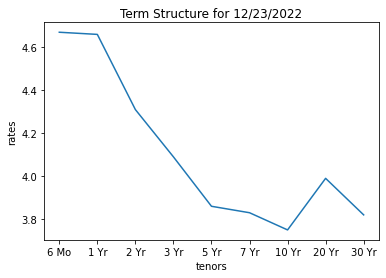

In [194]:
plt.ylabel(f'rates', fontsize=10)
plt.xlabel(f'tenors', fontsize=10)
fig=sns.lineplot(x=['6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr',
       '30 Yr'],y=[4.67, 4.66, 4.31, 4.09, 3.86, 3.83, 3.75, 3.99, 3.82],).set_title(f'Term Structure for 12/23/2022')

In [195]:
df.describe()[1:]*100

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr
mean,247.534694,276.502041,296.400000,302.963265,298.371429,298.987755
std,151.867702,138.084692,110.450582,98.099788,82.600490,75.911482
min,22.000000,38.000000,77.000000,102.000000,137.000000,155.000000
25%,108.000000,169.000000,235.000000,255.000000,255.000000,252.000000
50%,255.000000,288.000000,303.000000,302.000000,298.000000,299.000000
75%,387.000000,405.000000,411.000000,396.000000,367.000000,361.000000
max,478.000000,480.000000,472.000000,466.000000,445.000000,436.000000


In [196]:
vix=yf.download('^VIX',start=df.index[0],end=df.index[-1],progress=False)[['Adj Close']].round(2)
vix.rename(columns={'Adj Close': 'vix_price'}, inplace=True)
vix_returns=np.log(vix/vix.shift(1))
vix_returns.rename(columns={'Adj Close': 'vix_returns'}, inplace=True)
vix_returns.head()

,vix_price
Date,
2022-01-03,NaN
2022-01-04,0.018502
2022-01-05,0.154235
2022-01-06,-0.006101
2022-01-07,-0.044313


In [197]:
nasdaq=yf.download('^IXIC',start=df.index[0],end=df.index[-1],progress=False)[['Adj Close']].round(2)
nasdaq.rename(columns={'Adj Close': 'index_price'}, inplace=True)
nasdaq_returns=np.log(nasdaq/nasdaq.shift(1))
nasdaq_returns.rename(columns={'Adj Close': 'index_returns'}, inplace=True)
nasdaq_returns.head()

,index_price
Date,
2022-01-03,NaN
2022-01-04,-0.013357
2022-01-05,-0.034020
2022-01-06,-0.001280
2022-01-07,-0.009659


In [198]:
nasdaq_option=yf.download('NDAQ',start=df.index[0],end=df.index[-1],progress=False)[['Adj Close']].round(2)
nasdaq_option.rename(columns={'Adj Close': 'index_option_price'}, inplace=True)
nasdaq_optio_return=np.log(nasdaq/nasdaq.shift(1))
nasdaq_optio_return.rename(columns={'Adj Close': 'index_option_returns'}, inplace=True)
nasdaq_optio_return.head()

,index_price
Date,
2022-01-03,NaN
2022-01-04,-0.013357
2022-01-05,-0.034020
2022-01-06,-0.001280
2022-01-07,-0.009659


In [199]:
df.index[-1]

Timestamp('2022-12-23 00:00:00')

In [201]:
final=pd.merge(nasdaq,vix,on='Date').merge(df,how='left',on='Date').dropna()
last_traded_price=final.iloc[[-1]]
last_traded_price

,index_price,vix_price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr
Date,,,,,,,,
2022-12-22,10476.12,21.97,4.66,4.64,4.24,4.02,3.79,3.77


In [202]:
final_returns=pd.merge(nasdaq_returns,vix_returns,on='Date').merge(np.log(df/df.shift(1)),how='left',on='Date').dropna()

volatility=pd.DataFrame(np.std(final_returns)*100,columns=['volatility']).round(2).T
volatility.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, volatility to volatility
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index_price  1 non-null      float64
 1   vix_price    1 non-null      float64
 2   6 Mo         1 non-null      float64
 3   1 Yr         1 non-null      float64
 4   2 Yr         1 non-null      float64
 5   3 Yr         1 non-null      float64
 6   5 Yr         1 non-null      float64
 7   7 Yr         1 non-null      float64
dtypes: float64(8)
memory usage: 180.0+ bytes


In [203]:
risk_factor_info=pd.concat([volatility,last_traded_price])
risk_factor_info

,index_price,vix_price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr
volatility,2.03,6.76,4.19,3.80,3.33,3.21,3.05,2.92
2022-12-22 00:00:00,10476.12,21.97,4.66,4.64,4.24,4.02,3.79,3.77


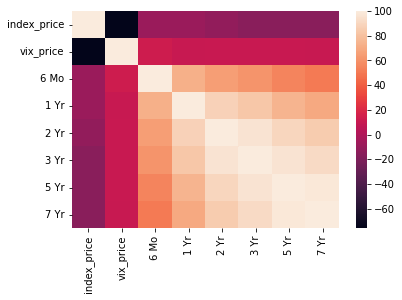

In [204]:
risk_factor_cor=final_returns.corr().round(2)*100
risk_factor_cor

sns.heatmap(risk_factor_cor)

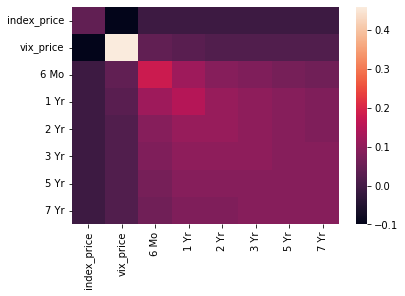

In [205]:
risk_factor_cov=final_returns.cov().round(4)*100
risk_factor_cov
sns.heatmap(risk_factor_cov)

In [242]:
print(f'Portfolio of Different Securities')
print()
print(f'equity{" - Nasdaq : ^IXIC"} Linear risk ' )
spot = nasdaq.tail(1).values[0][0]
Notional = 10000
Present_value = Notional
delta_equity=Present_value/spot
delta_equity
print()
print(f'option{" - Ticker : NDAQ " "call option" }')
delta_call=1/100
vega_call=1/1000
pvo1_call=2/100
print()
print(f'bond{" 5 - Year Bonds "}')
pvo1_bond=0.52
pvo1_bond

Portfolio of Different Securities

equity - Nasdaq : ^IXIC Linear risk 

option - Ticker : NDAQ call option

bond 5 - Year Bonds 


0.52

NameError: ignored

In [208]:
print(f'Risk Factor Mapping w.r.t Securitites')
print()
last_traded_price.values[0]

Risk Factor Mapping w.r.t Securitites



array([1.047612e+04, 2.197000e+01, 4.660000e+00, 4.640000e+00,
       4.240000e+00, 4.020000e+00, 3.790000e+00, 3.770000e+00])

In [247]:
last_traded_price.index_price.values[0]*delta_equity*(volatility.index_price.values[0])

20299.999999999996

In [246]:
last_traded_price.vix_price.values[0]*delta_call*(volatility.vix_price.values[0]),last_traded_price.vix_price.values[0]*vega_call*(volatility.vix_price.values[0]),last_traded_price.vix_price.values[0]*pvo1*(volatility.vix_price.values[0])

(1.485172, 0.1485172, 77.228944)

In [248]:
last_traded_price['1 Yr'].values[0]*pvo1_bond*(volatility['1 Yr'].values[0])

9.168639999999998

In [271]:
df=pd.DataFrame(([last_traded_price.index_price.values[0]*delta_equity*(volatility.index_price.values[0]),0,0,0],
[0,0,0,0],
[0,0,0,0],
)
,index=['equity','option','bond'],columns=['index','bond_1','bond_5','vix'])

In [273]:
df.round(3)

,index,bond_1,bond_5,vix
equity,20300.0,0,0,0
option,0.0,0,0,0
bond,0.0,0,0,0
